In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels
from statsmodels.tsa import stattools

In [2]:
df=pd.read_csv('BERLIN2.txt')

In [3]:
df

,STAID,SOUID,DATE,TG,Q_TG
0,2759,27488,18760101,22,0
1,2759,27488,18760102,25,0
2,2759,27488,18760103,3,0
3,2759,27488,18760104,-58,0
4,2759,27488,18760105,-98,0
...,...,...,...,...,...
53290,2759,11448,20211126,44,0
53291,2759,11448,20211127,19,0
53292,2759,11448,20211128,19,0
53293,2759,11448,20211129,24,0


###### Remove staid column

In [4]:
df1=df.drop('STAID',axis=1)

In [5]:
df1.isna().sum()

 SOUID      0
    DATE    0
   TG       0
 Q_TG       0
dtype: int64

###### Rename columns

In [6]:
df1.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [7]:
df1.rename(columns={' SOUID':'SOUID','    DATE':'Date','   TG':'TG',' Q_TG':'QTG'},inplace=True)

In [8]:
df1.columns

Index(['SOUID', 'Date', 'TG', 'QTG'], dtype='object')

###### date column in datetime

In [9]:
df1['Date']=pd.to_datetime(df1['Date'],format='%Y%m%d')

In [10]:
df1['year']=df1['Date'].dt.year

In [11]:
df1['month']=df1['Date'].dt.month

In [12]:
df1['day']=df1['Date'].dt.day

In [13]:
df1

,SOUID,Date,TG,QTG,year,month,day
0,27488,1876-01-01,22,0,1876,1,1
1,27488,1876-01-02,25,0,1876,1,2
2,27488,1876-01-03,3,0,1876,1,3
3,27488,1876-01-04,-58,0,1876,1,4
4,27488,1876-01-05,-98,0,1876,1,5
...,...,...,...,...,...,...,...
53290,11448,2021-11-26,44,0,2021,11,26
53291,11448,2021-11-27,19,0,2021,11,27
53292,11448,2021-11-28,19,0,2021,11,28
53293,11448,2021-11-29,24,0,2021,11,29


###### Removing columns with 'qtg' = value 9 (=missing data)

In [14]:
df2=df1

In [15]:
df2[df2['QTG']==9]

,SOUID,Date,TG,QTG,year,month,day
25316,27488,1945-04-25,-9999,9,1945,4,25
25317,27488,1945-04-26,-9999,9,1945,4,26
25318,27488,1945-04-27,-9999,9,1945,4,27
25319,27488,1945-04-28,-9999,9,1945,4,28
25320,27488,1945-04-29,-9999,9,1945,4,29
...,...,...,...,...,...,...,...
25506,27488,1945-11-01,-9999,9,1945,11,1
25507,27488,1945-11-02,-9999,9,1945,11,2
25508,27488,1945-11-03,-9999,9,1945,11,3
25509,27488,1945-11-04,-9999,9,1945,11,4


In [16]:
#df1['TG']=df1['TG'].replace(-9999,np.NaN)

In [17]:
df2['TG']=df2['TG'].replace(-9999,df2['TG'].mean())

In [18]:
df2[df2['QTG']==9]

,SOUID,Date,TG,QTG,year,month,day
25316,27488,1945-04-25,57.081246,9,1945,4,25
25317,27488,1945-04-26,57.081246,9,1945,4,26
25318,27488,1945-04-27,57.081246,9,1945,4,27
25319,27488,1945-04-28,57.081246,9,1945,4,28
25320,27488,1945-04-29,57.081246,9,1945,4,29
...,...,...,...,...,...,...,...
25506,27488,1945-11-01,57.081246,9,1945,11,1
25507,27488,1945-11-02,57.081246,9,1945,11,2
25508,27488,1945-11-03,57.081246,9,1945,11,3
25509,27488,1945-11-04,57.081246,9,1945,11,4


In [19]:
#df1.drop(df1[df1['QTG'] == 9].index, inplace = True) 

In [20]:
#df1[df1['QTG']==9]

###### multiply column 'TG' with 0.1 to get celsius

In [21]:
df2['TG']=df2['TG']*0.1

###### group data by year and plotting the data

<AxesSubplot:xlabel='year'>

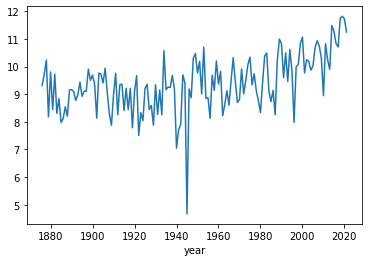

In [22]:
df2.groupby('year')['TG'].mean().plot()

In [23]:
#df2[df2['year']==1945]['TG'].plot() 

In [24]:
#df2.loc[22000:29000]['TG'].plot()

##### Timesteps

In [25]:
df2['timestep'] = range(len(df2))

In [26]:
df2.head(15)

,SOUID,Date,TG,QTG,year,month,day,timestep
0,27488,1876-01-01,2.2,0,1876,1,1,0
1,27488,1876-01-02,2.5,0,1876,1,2,1
2,27488,1876-01-03,0.3,0,1876,1,3,2
3,27488,1876-01-04,-5.8,0,1876,1,4,3
4,27488,1876-01-05,-9.8,0,1876,1,5,4
5,27488,1876-01-06,-7.7,0,1876,1,6,5
6,27488,1876-01-07,-6.6,0,1876,1,7,6
7,27488,1876-01-08,-8.9,0,1876,1,8,7
8,27488,1876-01-09,-12.7,0,1876,1,9,8
9,27488,1876-01-10,-8.9,0,1876,1,10,9


##### Seasonal Dummies

In [27]:
seasonal_dummies = pd.get_dummies(
    data=df2['month'],
    prefix='month',
    drop_first=True)

seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
53290,0,0,0,0,0,0,0,0,0,1,0
53291,0,0,0,0,0,0,0,0,0,1,0
53292,0,0,0,0,0,0,0,0,0,1,0
53293,0,0,0,0,0,0,0,0,0,1,0


In [28]:
df2 = df2.join(seasonal_dummies)
df2

,SOUID,Date,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,27488,1876-01-01,2.2,0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,27488,1876-01-02,2.5,0,1876,1,2,1,0,0,0,0,0,0,0,0,0,0,0
2,27488,1876-01-03,0.3,0,1876,1,3,2,0,0,0,0,0,0,0,0,0,0,0
3,27488,1876-01-04,-5.8,0,1876,1,4,3,0,0,0,0,0,0,0,0,0,0,0
4,27488,1876-01-05,-9.8,0,1876,1,5,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53290,11448,2021-11-26,4.4,0,2021,11,26,53290,0,0,0,0,0,0,0,0,0,1,0
53291,11448,2021-11-27,1.9,0,2021,11,27,53291,0,0,0,0,0,0,0,0,0,1,0
53292,11448,2021-11-28,1.9,0,2021,11,28,53292,0,0,0,0,0,0,0,0,0,1,0
53293,11448,2021-11-29,2.4,0,2021,11,29,53293,0,0,0,0,0,0,0,0,0,1,0


###### Split the data in train and test

In [29]:
df_train=df2[:-365]
df_test=df2[-365:]

In [30]:
X = df_train[['timestep']]
Y = df_train['TG']

In [31]:
m_trend=LinearRegression ()

m_trend.fit(X,Y)

LinearRegression()

In [32]:
df_train['trend']=m_trend.predict(X)
df_train

<ipython-input-32-41e3ce26b91e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend']=m_trend.predict(X)


,SOUID,Date,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend
0,27488,1876-01-01,2.2,0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0,0,8.480479
1,27488,1876-01-02,2.5,0,1876,1,2,1,0,0,0,0,0,0,0,0,0,0,0,8.480513
2,27488,1876-01-03,0.3,0,1876,1,3,2,0,0,0,0,0,0,0,0,0,0,0,8.480547
3,27488,1876-01-04,-5.8,0,1876,1,4,3,0,0,0,0,0,0,0,0,0,0,0,8.480581
4,27488,1876-01-05,-9.8,0,1876,1,5,4,0,0,0,0,0,0,0,0,0,0,0,8.480615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52925,11448,2020-11-26,4.1,0,2020,11,26,52925,0,0,0,0,0,0,0,0,0,1,0,10.277778
52926,11448,2020-11-27,6.2,0,2020,11,27,52926,0,0,0,0,0,0,0,0,0,1,0,10.277812
52927,11448,2020-11-28,3.6,0,2020,11,28,52927,0,0,0,0,0,0,0,0,0,1,0,10.277846
52928,11448,2020-11-29,1.7,0,2020,11,29,52928,0,0,0,0,0,0,0,0,0,1,0,10.277880


In [33]:
df_train.set_index(['Date'],inplace=True)

In [34]:
df_train

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend
Date,,,,,,,,,,,,,,,,,,,
1876-01-01,27488,2.2,0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0,0,8.480479
1876-01-02,27488,2.5,0,1876,1,2,1,0,0,0,0,0,0,0,0,0,0,0,8.480513
1876-01-03,27488,0.3,0,1876,1,3,2,0,0,0,0,0,0,0,0,0,0,0,8.480547
1876-01-04,27488,-5.8,0,1876,1,4,3,0,0,0,0,0,0,0,0,0,0,0,8.480581
1876-01-05,27488,-9.8,0,1876,1,5,4,0,0,0,0,0,0,0,0,0,0,0,8.480615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,0,0,0,0,0,0,1,0,10.277778
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,0,0,0,0,0,0,1,0,10.277812
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,0,0,0,0,0,0,1,0,10.277846


In [35]:
def plot_df(df, title='Temperatur over the years', ylim=True):
    '''
    Custom plotting function for plotting the Berlintemperatur dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('TG')
    if ylim:
        plt.ylim(ymin=-30)
    plt.show()

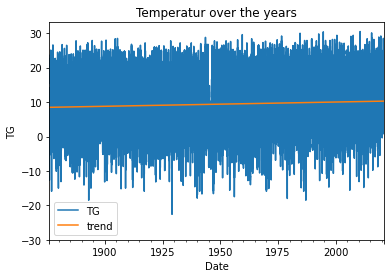

In [36]:
plot_df(df=df_train[['TG','trend']])

<ipython-input-37-b1c0355cedd3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['TG','trend'].mean().plot()


<AxesSubplot:xlabel='year'>

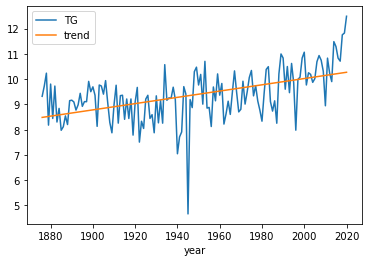

In [37]:
df_train.groupby('year')['TG','trend'].mean().plot()

In [38]:
df_train.columns

Index(['SOUID', 'TG', 'QTG', 'year', 'month', 'day', 'timestep', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'trend'],
      dtype='object')

In [39]:
X = df_train.drop(['day','QTG','SOUID','year','TG', 'month', 'trend'],axis=1) 
y= df_train['TG']

In [40]:
X

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,52925,0,0,0,0,0,0,0,0,0,1,0
2020-11-27,52926,0,0,0,0,0,0,0,0,0,1,0
2020-11-28,52927,0,0,0,0,0,0,0,0,0,1,0


In [41]:
y

Date
1876-01-01    2.2
1876-01-02    2.5
1876-01-03    0.3
1876-01-04   -5.8
1876-01-05   -9.8
             ... 
2020-11-26    4.1
2020-11-27    6.2
2020-11-28    3.6
2020-11-29    1.7
2020-11-30    1.6
Name: TG, Length: 52930, dtype: float64

In [42]:
m_season = LinearRegression()

In [43]:
m_season.fit(X,y)

LinearRegression()

In [44]:
df_train['trend_season'] = m_season.predict(X)
df_train.head(15)

<ipython-input-44-88e0b34e77c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend_season'] = m_season.predict(X)


,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_season
Date,,,,,,,,,,,,,,,,,,,,
1876-01-01,27488,2.2,0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0,0,8.480479,-0.877643
1876-01-02,27488,2.5,0,1876,1,2,1,0,0,0,0,0,0,0,0,0,0,0,8.480513,-0.877611
1876-01-03,27488,0.3,0,1876,1,3,2,0,0,0,0,0,0,0,0,0,0,0,8.480547,-0.877578
1876-01-04,27488,-5.8,0,1876,1,4,3,0,0,0,0,0,0,0,0,0,0,0,8.480581,-0.877545
1876-01-05,27488,-9.8,0,1876,1,5,4,0,0,0,0,0,0,0,0,0,0,0,8.480615,-0.877512
1876-01-06,27488,-7.7,0,1876,1,6,5,0,0,0,0,0,0,0,0,0,0,0,8.480649,-0.877479
1876-01-07,27488,-6.6,0,1876,1,7,6,0,0,0,0,0,0,0,0,0,0,0,8.480683,-0.877447
1876-01-08,27488,-8.9,0,1876,1,8,7,0,0,0,0,0,0,0,0,0,0,0,8.480717,-0.877414
1876-01-09,27488,-12.7,0,1876,1,9,8,0,0,0,0,0,0,0,0,0,0,0,8.480751,-0.877381


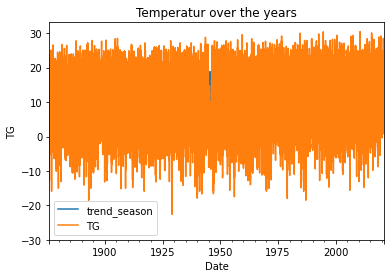

In [45]:
plot_df(df_train[['trend_season','TG']])

<ipython-input-46-4a337e3d7fce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['TG','trend_season'].mean().plot()


<AxesSubplot:xlabel='year'>

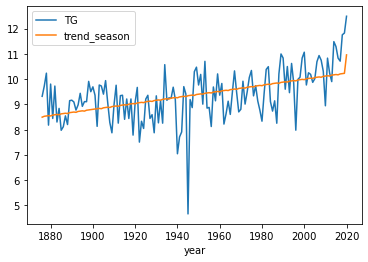

In [46]:
df_train.groupby('year')['TG','trend_season'].mean().plot()

In [47]:
df_train

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_season
Date,,,,,,,,,,,,,,,,,,,,
1876-01-01,27488,2.2,0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0,0,8.480479,-0.877643
1876-01-02,27488,2.5,0,1876,1,2,1,0,0,0,0,0,0,0,0,0,0,0,8.480513,-0.877611
1876-01-03,27488,0.3,0,1876,1,3,2,0,0,0,0,0,0,0,0,0,0,0,8.480547,-0.877578
1876-01-04,27488,-5.8,0,1876,1,4,3,0,0,0,0,0,0,0,0,0,0,0,8.480581,-0.877545
1876-01-05,27488,-9.8,0,1876,1,5,4,0,0,0,0,0,0,0,0,0,0,0,8.480615,-0.877512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,0,0,0,0,0,0,1,0,10.277778,5.429115
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,0,0,0,0,0,0,1,0,10.277812,5.429148
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,0,0,0,0,0,0,1,0,10.277846,5.429181


###### Extract remainder

In [48]:
df_train['remainder'] = df_train['TG'] - df_train['trend_season']

<ipython-input-48-e54e63d331b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['remainder'] = df_train['TG'] - df_train['trend_season']


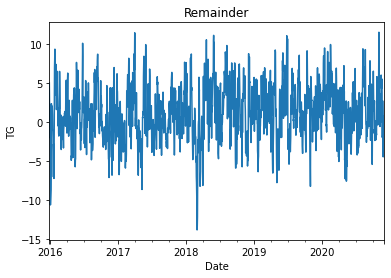

In [49]:
plot_df(df_train['remainder'].tail(1800),title = "Remainder",ylim=False)

In [50]:
df_train['remainder'].mean(), df_train['remainder'].std()

(6.744735970269542e-16, 3.9690509911209233)

In [51]:
df_train['remainder'].to_csv('../Woche7_Time_Series_Analysis/tRemainder.csv')

#### How much lags are needed to improve the prediction

In [52]:
rdf=pd.read_csv('tRemainder.csv',index_col=['Date'],parse_dates=['Date'])

In [53]:
rdf

,remainder
Date,
1876-01-01,3.077643
1876-01-02,3.377611
1876-01-03,1.177578
1876-01-04,-4.922455
1876-01-05,-8.922488
...,...
2020-11-26,-1.329115
2020-11-27,0.770852
2020-11-28,-1.829181


In [54]:
rdf['lag1'] = rdf['remainder'].shift(1)

In [55]:
rdf['lag2'] = rdf['remainder'].shift(2)

In [56]:
round(rdf[['remainder', 'lag1', 'lag2']].corr(), 2)

,remainder,lag1,lag2
remainder,1.00,0.81,0.61
lag1,0.81,1.00,0.81
lag2,0.61,0.81,1.00


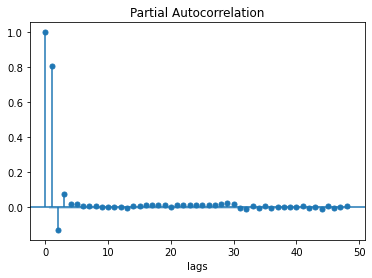

In [57]:
plot_pacf(rdf['remainder'])
plt.xlabel('lags');

In [58]:
rdf['lag3'] = rdf['remainder'].shift(3)

In [59]:
rdf['lag4'] = rdf['remainder'].shift(4)

In [60]:
rdf.dropna(inplace=True)
rdf.head()

,remainder,lag1,lag2,lag3,lag4
Date,,,,,
1876-01-05,-8.922488,-4.922455,1.177578,3.377611,3.077643
1876-01-06,-6.822521,-8.922488,-4.922455,1.177578,3.377611
1876-01-07,-5.722553,-6.822521,-8.922488,-4.922455,1.177578
1876-01-08,-8.022586,-5.722553,-6.822521,-8.922488,-4.922455
1876-01-09,-11.822619,-8.022586,-5.722553,-6.822521,-8.922488


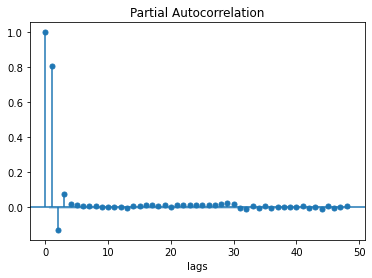

In [61]:
plot_pacf(rdf['remainder'])
plt.xlabel('lags');

In [62]:
Xr = rdf[['lag1','lag2','lag3','lag4']]
yr = rdf['remainder']

In [63]:
m = LinearRegression()
m.fit(Xr, yr)

LinearRegression()

In [64]:
rdf['predictions_ar1'] = m.predict(Xr)
rdf.head()

,remainder,lag1,lag2,lag3,lag4,predictions_ar1
Date,,,,,,
1876-01-05,-8.922488,-4.922455,1.177578,3.377611,3.077643,-4.514045
1876-01-06,-6.822521,-8.922488,-4.922455,1.177578,3.377611,-7.140146
1876-01-07,-5.722553,-6.822521,-8.922488,-4.922455,1.177578,-4.817780
1876-01-08,-8.022586,-5.722553,-6.822521,-8.922488,-4.922455,-4.549411
1876-01-09,-11.822619,-8.022586,-5.722553,-6.822521,-8.922488,-6.838690


In [65]:
m.coef_

array([ 0.92121823, -0.19284535,  0.05602615,  0.01899418])

In [66]:
select_order=ar_select_order(rdf['remainder'],maxlag=12)

C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [67]:
print (f"{select_order.ar_lags}")

[1 2 3 4 5]


In [68]:
m.score(Xr,yr)

0.6613903623141641

In [69]:
rdf['lag5'] = rdf['remainder'].shift(5)
rdf.head()

,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5
Date,,,,,,,
1876-01-05,-8.922488,-4.922455,1.177578,3.377611,3.077643,-4.514045,NaN
1876-01-06,-6.822521,-8.922488,-4.922455,1.177578,3.377611,-7.140146,NaN
1876-01-07,-5.722553,-6.822521,-8.922488,-4.922455,1.177578,-4.817780,NaN
1876-01-08,-8.022586,-5.722553,-6.822521,-8.922488,-4.922455,-4.549411,NaN
1876-01-09,-11.822619,-8.022586,-5.722553,-6.822521,-8.922488,-6.838690,NaN


In [70]:
rdf.dropna(inplace=True)
rdf.head()

,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5
Date,,,,,,,
1876-01-10,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521,-9.794285,-8.922488
1876-01-11,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553,-5.668837,-6.822521
1876-01-12,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586,-4.170972,-5.722553
1876-01-13,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619,-3.077010,-8.022586
1876-01-14,-2.722783,-2.622750,-3.722717,-5.322684,-8.022652,-2.148800,-11.822619


In [71]:
round(rdf[['remainder', 'lag1', 'lag2','lag3','lag4','lag5']].corr(), 2)

,remainder,lag1,lag2,lag3,lag4,lag5
remainder,1.00,0.81,0.61,0.48,0.39,0.32
lag1,0.81,1.00,0.81,0.61,0.48,0.39
lag2,0.61,0.81,1.00,0.81,0.61,0.48
lag3,0.48,0.61,0.81,1.00,0.81,0.61
lag4,0.39,0.48,0.61,0.81,1.00,0.81
lag5,0.32,0.39,0.48,0.61,0.81,1.00


In [72]:
Xr = rdf[['lag1','lag2','lag3','lag4','lag5']]
yr = rdf['remainder']

In [73]:
m = LinearRegression()
m.fit(Xr, yr)

LinearRegression()

In [74]:
rdf['predictions_ar1'] = m.predict(Xr)
rdf.head(7)

,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5
Date,,,,,,,
1876-01-10,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521,-9.841696,-8.922488
1876-01-11,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553,-5.704593,-6.822521
1876-01-12,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586,-4.171037,-5.722553
1876-01-13,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619,-3.049253,-8.022586
1876-01-14,-2.722783,-2.622750,-3.722717,-5.322684,-8.022652,-2.231229,-11.822619
1876-01-15,-2.222816,-2.722783,-2.622750,-3.722717,-5.322684,-2.369620,-8.022652
1876-01-16,-1.422848,-2.222816,-2.722783,-2.622750,-3.722717,-1.774989,-5.322684


In [75]:
m.score(Xr,yr)

0.6613979238412652

#### 4 lags are needed. The improve from 4-5 is unneccessary small 

In [76]:
df_train.head(10)

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_season,remainder
Date,,,,,,,,,,,,,,,,,,,,,
1876-01-01,27488,2.2,0,1876,1,1,0,0,0,0,...,0,0,0,0,0,0,0,8.480479,-0.877643,3.077643
1876-01-02,27488,2.5,0,1876,1,2,1,0,0,0,...,0,0,0,0,0,0,0,8.480513,-0.877611,3.377611
1876-01-03,27488,0.3,0,1876,1,3,2,0,0,0,...,0,0,0,0,0,0,0,8.480547,-0.877578,1.177578
1876-01-04,27488,-5.8,0,1876,1,4,3,0,0,0,...,0,0,0,0,0,0,0,8.480581,-0.877545,-4.922455
1876-01-05,27488,-9.8,0,1876,1,5,4,0,0,0,...,0,0,0,0,0,0,0,8.480615,-0.877512,-8.922488
1876-01-06,27488,-7.7,0,1876,1,6,5,0,0,0,...,0,0,0,0,0,0,0,8.480649,-0.877479,-6.822521
1876-01-07,27488,-6.6,0,1876,1,7,6,0,0,0,...,0,0,0,0,0,0,0,8.480683,-0.877447,-5.722553
1876-01-08,27488,-8.9,0,1876,1,8,7,0,0,0,...,0,0,0,0,0,0,0,8.480717,-0.877414,-8.022586
1876-01-09,27488,-12.7,0,1876,1,9,8,0,0,0,...,0,0,0,0,0,0,0,8.480751,-0.877381,-11.822619


In [77]:
df_train_new=df_train.loc['1876-01-10':,:]

In [78]:
df_train_new

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,trend_season,remainder
Date,,,,,,,,,,,,,,,,,,,,,
1876-01-10,27488,-8.9,0,1876,1,10,9,0,0,0,...,0,0,0,0,0,0,0,8.480785,-0.877348,-8.022652
1876-01-11,27488,-6.2,0,1876,1,11,10,0,0,0,...,0,0,0,0,0,0,0,8.480819,-0.877316,-5.322684
1876-01-12,27488,-4.6,0,1876,1,12,11,0,0,0,...,0,0,0,0,0,0,0,8.480853,-0.877283,-3.722717
1876-01-13,27488,-3.5,0,1876,1,13,12,0,0,0,...,0,0,0,0,0,0,0,8.480887,-0.877250,-2.622750
1876-01-14,27488,-3.6,0,1876,1,14,13,0,0,0,...,0,0,0,0,0,0,0,8.480921,-0.877217,-2.722783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,...,0,0,0,0,0,1,0,10.277778,5.429115,-1.329115
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,...,0,0,0,0,0,1,0,10.277812,5.429148,0.770852
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,...,0,0,0,0,0,1,0,10.277846,5.429181,-1.829181


In [79]:
rdf

,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5
Date,,,,,,,
1876-01-10,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521,-9.841696,-8.922488
1876-01-11,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553,-5.704593,-6.822521
1876-01-12,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586,-4.171037,-5.722553
1876-01-13,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619,-3.049253,-8.022586
1876-01-14,-2.722783,-2.622750,-3.722717,-5.322684,-8.022652,-2.231229,-11.822619
...,...,...,...,...,...,...,...
2020-11-26,-1.329115,-4.429083,-2.029050,1.170983,2.771016,-3.629980,-1.628951
2020-11-27,0.770852,-1.329115,-4.429083,-2.029050,1.170983,-0.436475,2.771016
2020-11-28,-1.829181,0.770852,-1.329115,-4.429083,-2.029050,0.715875,1.170983


In [80]:
rdf=rdf.drop('remainder',axis=1)

In [81]:
def concat_df_fe(df1,df2):
    
    return  pd.concat([df1,df2],axis=1)

In [82]:
df_train_done =concat_df_fe(df1=df_train_new, df2=rdf)

In [83]:
df_train_done

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,month_12,trend,trend_season,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5
Date,,,,,,,,,,,,,,,,,,,,,
1876-01-10,27488,-8.9,0,1876,1,10,9,0,0,0,...,0,8.480785,-0.877348,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521,-9.841696,-8.922488
1876-01-11,27488,-6.2,0,1876,1,11,10,0,0,0,...,0,8.480819,-0.877316,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553,-5.704593,-6.822521
1876-01-12,27488,-4.6,0,1876,1,12,11,0,0,0,...,0,8.480853,-0.877283,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586,-4.171037,-5.722553
1876-01-13,27488,-3.5,0,1876,1,13,12,0,0,0,...,0,8.480887,-0.877250,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619,-3.049253,-8.022586
1876-01-14,27488,-3.6,0,1876,1,14,13,0,0,0,...,0,8.480921,-0.877217,-2.722783,-2.622750,-3.722717,-5.322684,-8.022652,-2.231229,-11.822619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,...,0,10.277778,5.429115,-1.329115,-4.429083,-2.029050,1.170983,2.771016,-3.629980,-1.628951
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,...,0,10.277812,5.429148,0.770852,-1.329115,-4.429083,-2.029050,1.170983,-0.436475,2.771016
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,...,0,10.277846,5.429181,-1.829181,0.770852,-1.329115,-4.429083,-2.029050,0.715875,1.170983


##### Run the a full Model

In [84]:
X_full = df_train_done.drop(columns=['trend','TG', 'trend_season', 'remainder','SOUID','QTG','year','month','day','predictions_ar1'])
y_full = df_train_done['TG']

In [85]:
X_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,,,,,,,,,,,
1876-01-10,9,0,0,0,0,0,0,0,0,0,0,0,-11.822619,-8.022586,-5.722553,-6.822521,-8.922488
1876-01-11,10,0,0,0,0,0,0,0,0,0,0,0,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521
1876-01-12,11,0,0,0,0,0,0,0,0,0,0,0,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553
1876-01-13,12,0,0,0,0,0,0,0,0,0,0,0,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586
1876-01-14,13,0,0,0,0,0,0,0,0,0,0,0,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,52925,0,0,0,0,0,0,0,0,0,1,0,-4.429083,-2.029050,1.170983,2.771016,-1.628951
2020-11-27,52926,0,0,0,0,0,0,0,0,0,1,0,-1.329115,-4.429083,-2.029050,1.170983,2.771016
2020-11-28,52927,0,0,0,0,0,0,0,0,0,1,0,0.770852,-1.329115,-4.429083,-2.029050,1.170983


In [86]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [87]:
df_train_done['predict_full_model'] = m_full.predict(X_full)

In [88]:
df_train_done.tail()

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,trend,trend_season,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,...,10.277778,5.429115,-1.329115,-4.429083,-2.029050,1.170983,2.771016,-3.629980,-1.628951,1.818591
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,...,10.277812,5.429148,0.770852,-1.329115,-4.429083,-2.029050,1.170983,-0.436475,2.771016,5.012637
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,...,10.277846,5.429181,-1.829181,0.770852,-1.329115,-4.429083,-2.029050,0.715875,1.170983,6.164531
2020-11-29,11448,1.7,0,2020,11,29,52928,0,0,0,...,10.277880,5.429214,-3.729214,-1.829181,0.770852,-1.329115,-4.429083,-1.963077,-2.029050,3.485284
2020-11-30,11448,1.6,0,2020,11,30,52929,0,0,0,...,10.277914,5.429246,-3.829246,-3.729214,-1.829181,0.770852,-1.329115,-3.110153,-4.429083,2.337835


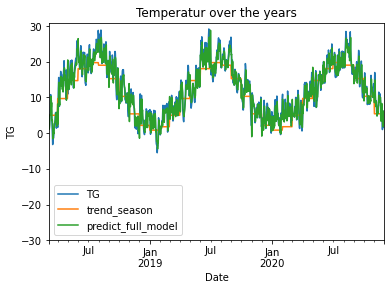

In [89]:
plot_df(df=df_train_done[['TG','trend_season','predict_full_model']].tail(1000))

In [90]:
pd.DataFrame(m_full.coef_.reshape(1,17), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
0,0.000033,0.959674,4.181256,8.836216,13.862876,17.167058,18.87975,18.116732,14.391677,9.423498,4.559231,1.337589,0.920678,-0.193589,0.059078,0.004287,0.016189


###### Evaluating the model

In [91]:
ts_split = TimeSeriesSplit(n_splits=10)

In [92]:
time_series_split = ts_split.split(X_full, y_full) 

In [93]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.91908551, 0.90756601, 0.89481662, 0.91364485, 0.91548297,
       0.91174368, 0.91224995, 0.90703163, 0.91658584, 0.91970258])

In [94]:
result.mean()

0.9117909652977623

###### Testing my model

In [95]:
df_test

,SOUID,Date,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
52930,11448,2020-12-01,2.4,0,2020,12,1,52930,0,0,0,0,0,0,0,0,0,0,1
52931,11448,2020-12-02,-0.9,0,2020,12,2,52931,0,0,0,0,0,0,0,0,0,0,1
52932,11448,2020-12-03,-0.7,0,2020,12,3,52932,0,0,0,0,0,0,0,0,0,0,1
52933,11448,2020-12-04,1.4,0,2020,12,4,52933,0,0,0,0,0,0,0,0,0,0,1
52934,11448,2020-12-05,3.6,0,2020,12,5,52934,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53290,11448,2021-11-26,4.4,0,2021,11,26,53290,0,0,0,0,0,0,0,0,0,1,0
53291,11448,2021-11-27,1.9,0,2021,11,27,53291,0,0,0,0,0,0,0,0,0,1,0
53292,11448,2021-11-28,1.9,0,2021,11,28,53292,0,0,0,0,0,0,0,0,0,1,0
53293,11448,2021-11-29,2.4,0,2021,11,29,53293,0,0,0,0,0,0,0,0,0,1,0


In [96]:
Xtest=df_test.drop(columns=['TG','SOUID','Date','QTG','year','month','day'])
Xtest

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
52930,52930,0,0,0,0,0,0,0,0,0,0,1
52931,52931,0,0,0,0,0,0,0,0,0,0,1
52932,52932,0,0,0,0,0,0,0,0,0,0,1
52933,52933,0,0,0,0,0,0,0,0,0,0,1
52934,52934,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
53290,53290,0,0,0,0,0,0,0,0,0,1,0
53291,53291,0,0,0,0,0,0,0,0,0,1,0
53292,53292,0,0,0,0,0,0,0,0,0,1,0
53293,53293,0,0,0,0,0,0,0,0,0,1,0


In [97]:
ytest=df_test['TG']

In [98]:
df_test['trend_season']= m_season.predict(Xtest)

<ipython-input-98-48bb47b8b502>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['trend_season']= m_season.predict(Xtest)


In [99]:
df_test

,SOUID,Date,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_season
52930,11448,2020-12-01,2.4,0,2020,12,1,52930,0,0,0,0,0,0,0,0,0,0,1,2.208154
52931,11448,2020-12-02,-0.9,0,2020,12,2,52931,0,0,0,0,0,0,0,0,0,0,1,2.208187
52932,11448,2020-12-03,-0.7,0,2020,12,3,52932,0,0,0,0,0,0,0,0,0,0,1,2.208220
52933,11448,2020-12-04,1.4,0,2020,12,4,52933,0,0,0,0,0,0,0,0,0,0,1,2.208252
52934,11448,2020-12-05,3.6,0,2020,12,5,52934,0,0,0,0,0,0,0,0,0,0,1,2.208285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53290,11448,2021-11-26,4.4,0,2021,11,26,53290,0,0,0,0,0,0,0,0,0,1,0,5.441078
53291,11448,2021-11-27,1.9,0,2021,11,27,53291,0,0,0,0,0,0,0,0,0,1,0,5.441111
53292,11448,2021-11-28,1.9,0,2021,11,28,53292,0,0,0,0,0,0,0,0,0,1,0,5.441144
53293,11448,2021-11-29,2.4,0,2021,11,29,53293,0,0,0,0,0,0,0,0,0,1,0,5.441177


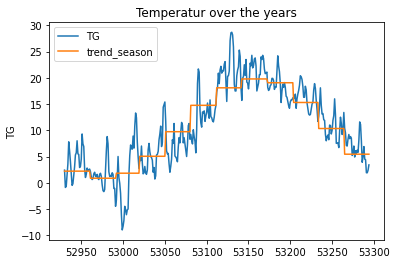

In [100]:
plot_df(df_test[['TG', 'trend_season']], ylim=False)

In [101]:
df_test['remainder'] = df_test['TG'] - df_test['trend_season']

<ipython-input-101-8728d0231561>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['remainder'] = df_test['TG'] - df_test['trend_season']


###### Creatung lag's

In [102]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)
df_test['lag5'] = df_test['remainder'].shift(5)

<ipython-input-102-fae48393fdc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag1'] = df_test['remainder'].shift(1)
<ipython-input-102-fae48393fdc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lag2'] = df_test['remainder'].shift(2)
<ipython-input-102-fae48393fdc7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [103]:
df_test

,SOUID,Date,TG,QTG,year,month,day,timestep,month_2,month_3,...,month_10,month_11,month_12,trend_season,remainder,lag1,lag2,lag3,lag4,lag5
52930,11448,2020-12-01,2.4,0,2020,12,1,52930,0,0,...,0,0,1,2.208154,0.191846,NaN,NaN,NaN,NaN,NaN
52931,11448,2020-12-02,-0.9,0,2020,12,2,52931,0,0,...,0,0,1,2.208187,-3.108187,0.191846,NaN,NaN,NaN,NaN
52932,11448,2020-12-03,-0.7,0,2020,12,3,52932,0,0,...,0,0,1,2.208220,-2.908220,-3.108187,0.191846,NaN,NaN,NaN
52933,11448,2020-12-04,1.4,0,2020,12,4,52933,0,0,...,0,0,1,2.208252,-0.808252,-2.908220,-3.108187,0.191846,NaN,NaN
52934,11448,2020-12-05,3.6,0,2020,12,5,52934,0,0,...,0,0,1,2.208285,1.391715,-0.808252,-2.908220,-3.108187,0.191846,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53290,11448,2021-11-26,4.4,0,2021,11,26,53290,0,0,...,0,1,0,5.441078,-1.041078,-0.941046,1.458987,-0.440980,-1.540947,2.559086
53291,11448,2021-11-27,1.9,0,2021,11,27,53291,0,0,...,0,1,0,5.441111,-3.541111,-1.041078,-0.941046,1.458987,-0.440980,-1.540947
53292,11448,2021-11-28,1.9,0,2021,11,28,53292,0,0,...,0,1,0,5.441144,-3.541144,-3.541111,-1.041078,-0.941046,1.458987,-0.440980
53293,11448,2021-11-29,2.4,0,2021,11,29,53293,0,0,...,0,1,0,5.441177,-3.041177,-3.541144,-3.541111,-1.041078,-0.941046,1.458987


In [104]:
df_test.set_index(['Date'],inplace=True)

In [105]:
X_full = df_test.drop(columns=['TG','trend_season', 'remainder','SOUID','QTG','year','month','day'])

In [106]:
df_train_done.tail(7)

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,trend,trend_season,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-24,11448,3.4,0,2020,11,24,52923,0,0,0,...,10.277711,5.429050,-2.029050,1.170983,2.771016,-1.628951,-1.928919,0.497667,3.771114,5.947001
2020-11-25,11448,1.0,0,2020,11,25,52924,0,0,0,...,10.277745,5.429083,-4.429083,-2.029050,1.170983,2.771016,-1.628951,-1.968893,-1.928919,3.479531
2020-11-26,11448,4.1,0,2020,11,26,52925,0,0,0,...,10.277778,5.429115,-1.329115,-4.429083,-2.029050,1.170983,2.771016,-3.629980,-1.628951,1.818591
2020-11-27,11448,6.2,0,2020,11,27,52926,0,0,0,...,10.277812,5.429148,0.770852,-1.329115,-4.429083,-2.029050,1.170983,-0.436475,2.771016,5.012637
2020-11-28,11448,3.6,0,2020,11,28,52927,0,0,0,...,10.277846,5.429181,-1.829181,0.770852,-1.329115,-4.429083,-2.029050,0.715875,1.170983,6.164531
2020-11-29,11448,1.7,0,2020,11,29,52928,0,0,0,...,10.277880,5.429214,-3.729214,-1.829181,0.770852,-1.329115,-4.429083,-1.963077,-2.029050,3.485284
2020-11-30,11448,1.6,0,2020,11,30,52929,0,0,0,...,10.277914,5.429246,-3.829246,-3.729214,-1.829181,0.770852,-1.329115,-3.110153,-4.429083,2.337835


In [107]:
X_full.head(7)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,,,,,,,,,,,
2020-12-01,52930,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN
2020-12-02,52931,0,0,0,0,0,0,0,0,0,0,1,0.191846,NaN,NaN,NaN,NaN
2020-12-03,52932,0,0,0,0,0,0,0,0,0,0,1,-3.108187,0.191846,NaN,NaN,NaN
2020-12-04,52933,0,0,0,0,0,0,0,0,0,0,1,-2.908220,-3.108187,0.191846,NaN,NaN
2020-12-05,52934,0,0,0,0,0,0,0,0,0,0,1,-0.808252,-2.908220,-3.108187,0.191846,NaN
2020-12-06,52935,0,0,0,0,0,0,0,0,0,0,1,1.391715,-0.808252,-2.908220,-3.108187,0.191846
2020-12-07,52936,0,0,0,0,0,0,0,0,0,0,1,5.591682,1.391715,-0.808252,-2.908220,-3.108187


###### replace NaN's with compatible remainder

In [108]:
X_full.loc['2020-12-01', 'lag1'] = df_train_done.loc['2020-11-30', 'remainder']
X_full.loc['2020-12-02', 'lag2'] = df_train_done.loc['2020-11-30', 'remainder']
X_full.loc['2020-12-03', 'lag3'] = df_train_done.loc['2020-11-30', 'remainder']
X_full.loc['2020-12-04', 'lag4'] = df_train_done.loc['2020-11-30', 'remainder']
X_full.loc['2020-12-05', 'lag5'] = df_train_done.loc['2020-11-30', 'remainder']
X_full.loc['2020-12-01', 'lag2'] = df_train_done.loc['2020-11-29', 'remainder']
X_full.loc['2020-12-02', 'lag3'] = df_train_done.loc['2020-11-29', 'remainder']
X_full.loc['2020-12-03', 'lag4'] = df_train_done.loc['2020-11-29', 'remainder']
X_full.loc['2020-12-04', 'lag5'] = df_train_done.loc['2020-11-29', 'remainder']
X_full.loc['2020-12-01', 'lag3'] = df_train_done.loc['2020-11-28', 'remainder']
X_full.loc['2020-12-02', 'lag4'] = df_train_done.loc['2020-11-28', 'remainder']
X_full.loc['2020-12-03', 'lag5'] = df_train_done.loc['2020-11-28', 'remainder']
X_full.loc['2020-12-01', 'lag4'] = df_train_done.loc['2020-11-27', 'remainder']
X_full.loc['2020-12-02', 'lag5'] = df_train_done.loc['2020-11-27', 'remainder']
X_full.loc['2020-12-01', 'lag5'] = df_train_done.loc['2020-11-26', 'remainder']

In [109]:
X_full.head(7)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,,,,,,,,,,,
2020-12-01,52930,0,0,0,0,0,0,0,0,0,0,1,-3.829246,-3.729214,-1.829181,0.770852,-1.329115
2020-12-02,52931,0,0,0,0,0,0,0,0,0,0,1,0.191846,-3.829246,-3.729214,-1.829181,0.770852
2020-12-03,52932,0,0,0,0,0,0,0,0,0,0,1,-3.108187,0.191846,-3.829246,-3.729214,-1.829181
2020-12-04,52933,0,0,0,0,0,0,0,0,0,0,1,-2.908220,-3.108187,0.191846,-3.829246,-3.729214
2020-12-05,52934,0,0,0,0,0,0,0,0,0,0,1,-0.808252,-2.908220,-3.108187,0.191846,-3.829246
2020-12-06,52935,0,0,0,0,0,0,0,0,0,0,1,1.391715,-0.808252,-2.908220,-3.108187,0.191846
2020-12-07,52936,0,0,0,0,0,0,0,0,0,0,1,5.591682,1.391715,-0.808252,-2.908220,-3.108187


In [110]:
df_test['predict_full_model'] = m_full.predict(X_full)

<ipython-input-110-d14f0e480ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict_full_model'] = m_full.predict(X_full)


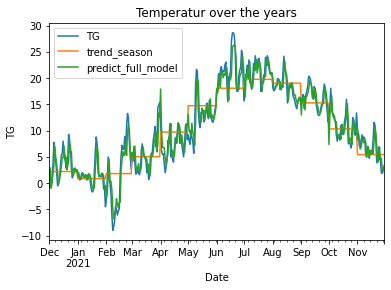

In [111]:
plot_df(df_test[['TG', 'trend_season', 'predict_full_model']], ylim=False)

In [112]:
df_full = df_train_done[['TG', 'trend_season', 'predict_full_model']].append(df_test[['TG', 'trend_season', 'predict_full_model']])

In [113]:
df_full.head()

,TG,trend_season,predict_full_model
Date,,,
1876-01-10,-8.9,-0.877348,-10.686259
1876-01-11,-6.2,-0.877316,-6.549203
1876-01-12,-4.6,-0.877283,-5.015554
1876-01-13,-3.5,-0.877250,-3.894184
1876-01-14,-3.6,-0.877217,-3.076891


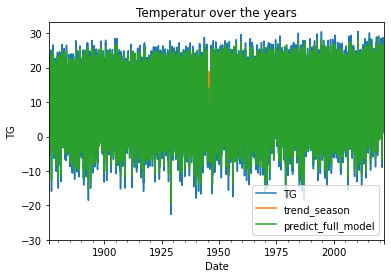

In [114]:
plot_df(df_full)

In [115]:
print(f"""
{m_full.score(X_full, df_test['TG'])}
{m_season.score(Xtest, df_test['TG'])}
""")



0.9269827802155172
0.7786780026320103



#### Into the future

In [116]:
df_test.head()

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,month_11,month_12,trend_season,remainder,lag1,lag2,lag3,lag4,lag5,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,11448,2.4,0,2020,12,1,52930,0,0,0,...,0,1,2.208154,0.191846,NaN,NaN,NaN,NaN,NaN,-0.702462
2020-12-02,11448,-0.9,0,2020,12,2,52931,0,0,0,...,0,1,2.208187,-3.108187,0.191846,NaN,NaN,NaN,NaN,2.929667
2020-12-03,11448,-0.7,0,2020,12,3,52932,0,0,0,...,0,1,2.208220,-2.908220,-3.108187,0.191846,NaN,NaN,NaN,-0.943156
2020-12-04,11448,1.4,0,2020,12,4,52933,0,0,0,...,0,1,2.208252,-0.808252,-2.908220,-3.108187,0.191846,NaN,NaN,0.086202
2020-12-05,11448,3.6,0,2020,12,5,52934,0,0,0,...,0,1,2.208285,1.391715,-0.808252,-2.908220,-3.108187,0.191846,NaN,1.801578


In [117]:
df_combined=df_train_done.append(df_test)

In [118]:
df_combined

,SOUID,TG,QTG,year,month,day,timestep,month_2,month_3,month_4,...,trend,trend_season,remainder,lag1,lag2,lag3,lag4,predictions_ar1,lag5,predict_full_model
Date,,,,,,,,,,,,,,,,,,,,,
1876-01-10,27488,-8.9,0,1876,1,10,9,0,0,0,...,8.480785,-0.877348,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521,-9.841696,-8.922488,-10.686259
1876-01-11,27488,-6.2,0,1876,1,11,10,0,0,0,...,8.480819,-0.877316,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553,-5.704593,-6.822521,-6.549203
1876-01-12,27488,-4.6,0,1876,1,12,11,0,0,0,...,8.480853,-0.877283,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586,-4.171037,-5.722553,-5.015554
1876-01-13,27488,-3.5,0,1876,1,13,12,0,0,0,...,8.480887,-0.877250,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619,-3.049253,-8.022586,-3.894184
1876-01-14,27488,-3.6,0,1876,1,14,13,0,0,0,...,8.480921,-0.877217,-2.722783,-2.622750,-3.722717,-5.322684,-8.022652,-2.231229,-11.822619,-3.076891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,11448,4.4,0,2021,11,26,53290,0,0,0,...,NaN,5.441078,-1.041078,-0.941046,1.458987,-0.440980,-1.540947,NaN,2.559086,4.320736
2021-11-27,11448,1.9,0,2021,11,27,53291,0,0,0,...,NaN,5.441111,-3.541111,-1.041078,-0.941046,1.458987,-0.440980,NaN,-1.540947,4.743878
2021-11-28,11448,1.9,0,2021,11,28,53292,0,0,0,...,NaN,5.441144,-3.541144,-3.541111,-1.041078,-0.941046,1.458987,NaN,-0.440980,2.345714


In [119]:
X_combined=df_combined.drop(columns=['SOUID','TG','QTG','year','month','day','trend','trend_season','remainder','predictions_ar1','predict_full_model'])
y_combined=df_combined['TG']

In [120]:
X_combined

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
Date,,,,,,,,,,,,,,,,,
1876-01-10,9,0,0,0,0,0,0,0,0,0,0,0,-11.822619,-8.022586,-5.722553,-6.822521,-8.922488
1876-01-11,10,0,0,0,0,0,0,0,0,0,0,0,-8.022652,-11.822619,-8.022586,-5.722553,-6.822521
1876-01-12,11,0,0,0,0,0,0,0,0,0,0,0,-5.322684,-8.022652,-11.822619,-8.022586,-5.722553
1876-01-13,12,0,0,0,0,0,0,0,0,0,0,0,-3.722717,-5.322684,-8.022652,-11.822619,-8.022586
1876-01-14,13,0,0,0,0,0,0,0,0,0,0,0,-2.622750,-3.722717,-5.322684,-8.022652,-11.822619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,53290,0,0,0,0,0,0,0,0,0,1,0,-0.941046,1.458987,-0.440980,-1.540947,2.559086
2021-11-27,53291,0,0,0,0,0,0,0,0,0,1,0,-1.041078,-0.941046,1.458987,-0.440980,-1.540947
2021-11-28,53292,0,0,0,0,0,0,0,0,0,1,0,-3.541111,-1.041078,-0.941046,1.458987,-0.440980


###### Create one single future step

In [121]:
timestep=df_combined['timestep'].max()+1
months=[0,0,0,0,0,0,0,0,0,0,1]
lag1=df_combined.loc['2021-11-30','remainder']
lag2=df_combined.loc['2021-11-30','lag1']
lag3=df_combined.loc['2021-11-30','lag2']
lag4=df_combined.loc['2021-11-30','lag3']
lag5=df_combined.loc['2021-11-30','lag4']

In [122]:
timestep,months,lag1,lag2,lag3,lag4,lag5

(53295,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 -2.0412094432833747,
 -3.0411766678832297,
 -3.5411438924830856,
 -3.5411111170829415,
 -1.0410783416827964)

In [123]:
X_future=[timestep]
X_future

[53295]

In [124]:
X_future.extend(months)
X_future

[53295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [125]:
X_future.append(lag1)
X_future

[53295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2.0412094432833747]

In [126]:
X_future.append(lag2)
X_future

[53295,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -2.0412094432833747,
 -3.0411766678832297]

In [127]:
X_future.append(lag3)
X_future

[53295,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -2.0412094432833747,
 -3.0411766678832297,
 -3.5411438924830856]

In [128]:
X_future.append(lag4)
X_future

[53295,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -2.0412094432833747,
 -3.0411766678832297,
 -3.5411438924830856,
 -3.5411111170829415]

In [129]:
X_future.append(lag5)
X_future

[53295,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -2.0412094432833747,
 -3.0411766678832297,
 -3.5411438924830856,
 -3.5411111170829415,
 -1.0410783416827964]

In [130]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
0,53295,0,0,0,0,0,0,0,0,0,0,1,-2.041209,-3.041177,-3.541144,-3.541111,-1.041078


In [131]:
m_full.predict(X_future)

array([0.70753444])

###### Two days in future

In [132]:
timestep = df_combined['timestep'].max() + 2
months = [1] + [0]*10
lag = 0 

In [133]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag1]+[lag2]+[lag3]+[lag4]+[lag5]])
X_future_2.columns = X_combined.columns
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5
0,53296,1,0,0,0,0,0,0,0,0,0,0,-2.041209,-3.041177,-3.541144,-3.541111,-1.041078


In [134]:
m_full.predict(X_future_2)

array([0.32965219])

###### Building Ar-model

In [135]:
ar_model = AutoReg(endog=df_combined['remainder'], lags=5).fit()

C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\bened\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [136]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53286
Model:                     AutoReg(5)   Log Likelihood             -120163.247
Method:               Conditional MLE   S.D. of innovations              2.308
Date:                Fri, 21 Jan 2022   AIC                              1.673
Time:                        14:48:32   BIC                              1.674
Sample:                    01-15-1876   HQIC                             1.673
                         - 11-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0007      0.010      0.069      0.945      -0.019       0.020
remainder.L1     0.9216      0.004    212.750      0.000       0.913       0.930
remainder.L2    -0.1940      0.006    -32.939      0.000      -0.206      -0.182
remainder.L3     0.0580      0.006      9.764      0.000       0.046       0.070
remainder.L4     0.0045      0.006      0.767      0.443      -0.007       0.016
remainder.L5     0.0162      0.004      3.733      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2258           -0.0000j            1.2258           -0.0000
AR.2            1.2257           -1.8586j            2.2264           -0.1572
AR.3            1.2257           +1.8586j            2.2264            0.1572
AR.4           -1.9783           -2.5027j            3.1902           -0.3565
AR.5           -1.9783           +2.5027j            3.1902            0.3565
-----------------------------------------------------------------------------
"""